In [31]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [35]:
df = dd.read_parquet("yellow_tripdata_2023-01.csv")

In [36]:
# Clean data: remove zero or negative fare and trip distance
df_clean = df[(df.trip_distance > 0) & (df.fare_amount > 0)]

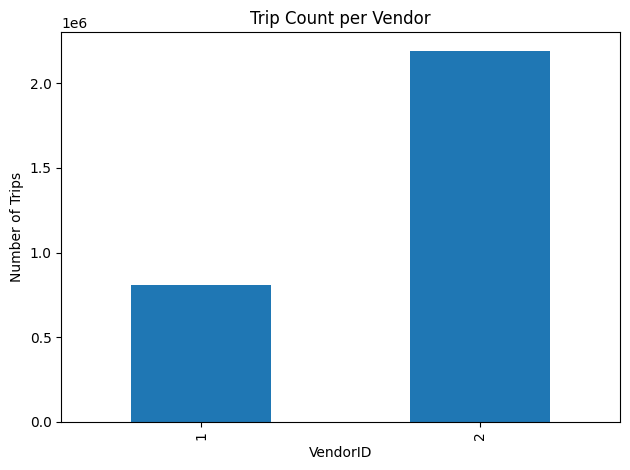

In [37]:
# Compute vendor trip count
vendor_counts = df_clean.groupby("VendorID").size().compute()
vendor_counts.plot(kind='bar', title='Trip Count per Vendor')
plt.xlabel('VendorID')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

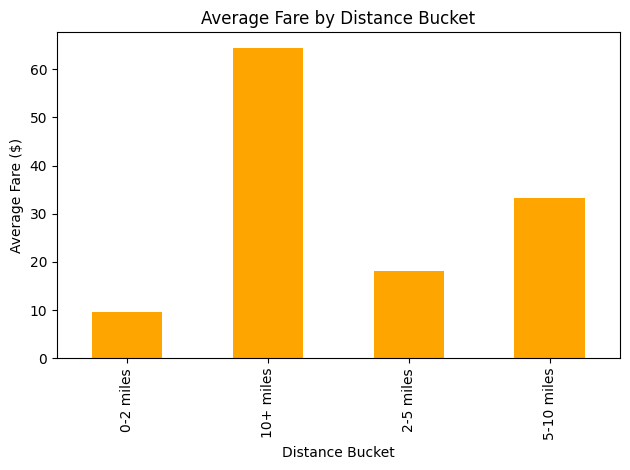

In [38]:
# Fare by distance bucket
def distance_bucket(dist):
    if dist < 2:
        return "0-2 miles"
    elif dist < 5:
        return "2-5 miles"
    elif dist < 10:
        return "5-10 miles"
    else:
        return "10+ miles"

df_clean['distance_bucket'] = df_clean['trip_distance'].map_partitions(lambda df: df.apply(lambda x: distance_bucket(x)), meta=('x', 'str'))
avg_fare_bucket = df_clean.groupby('distance_bucket')['fare_amount'].mean().compute()
avg_fare_bucket.plot(kind='bar', color='orange', title='Average Fare by Distance Bucket')
plt.ylabel('Average Fare ($)')
plt.xlabel('Distance Bucket')
plt.tight_layout()
plt.show()

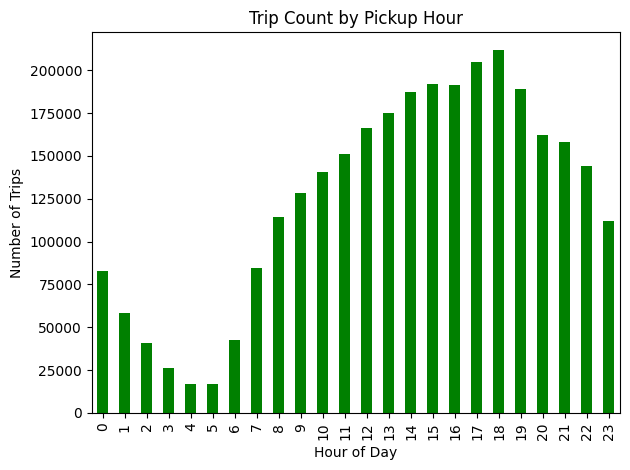

In [39]:
# Pickup hour histogram
df_clean['pickup_hour'] = dd.to_datetime(df_clean['tpep_pickup_datetime']).dt.hour
hourly_counts = df_clean.groupby("pickup_hour").size().compute()
hourly_counts.plot(kind='bar', color='green', title='Trip Count by Pickup Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

In [42]:
try:
    zones_df = pd.read_csv("yellow_tripdata_2023-01.csv", compression='gzip')
    df_location = df_clean[['PULocationID']].compute()
    zone_counts = df_location.merge(zones_df, left_on='PULocationID', right_on='LocationID')
    top_zones = zone_counts['Zone'].value_counts().nlargest(5)

    sns.barplot(x=top_zones.values, y=top_zones.index, palette="coolwarm")
    plt.title("Top 5 Pickup Zones")
    plt.xlabel("Number of Pickups")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Zone file not found or error in processing zone data:", e)


Zone file not found or error in processing zone data: Not a gzipped file (b'PA')
